In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from scipy import stats
import math 
import statistics 
from scipy.integrate import quad
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import chi2, t, f, norm

In [64]:
N = 50 # размерность выборки
p = 6 # количество признаков, 5 исходных и один свободный член
coef = np.array([3, -2, 1, 1, -1])

In [65]:
data = np.array([np.random.uniform(low = -1.0, high = 1.0, size = 5) for i in range(N)])

In [66]:
target = np.array([np.random.normal(2 + np.sum(i * coef), 1.5) for i in data])

## a) Проверить $ \xi_k $ на мультиколлинеарность 

In [67]:
R_2_res = []
for i in range(5):
    psi = np.ones((N,1))
    psi = np.hstack([psi, np.delete(data, i, 1)])
    y = data[:,i]
    F = psi.T @ psi
    F_1 = np.linalg.inv(F)
    beta = F_1@psi.T @ y
    rss = (y-psi @ beta).T @ (y-psi @ beta)
    tss = np.sum((y-y.mean())**2) 
    R_2_res.append(1-rss/tss)

In [68]:
R_2_res

[0.06620133834872466,
 0.060758699923755155,
 0.05745572604990423,
 0.01897619056198363,
 0.025702846578887106]

### четыре признака объясняют пятый не более чем на 70%, значит признаки не связаны

## b) Определить уравнение линейной регрессии $\eta=\beta_0+\sum_{k=1}^5\beta_k\xi_k$ и проверить значимость коэффициентов

In [69]:
psi = np.ones((N,1))
psi = np.hstack([psi, data])

F = psi.T @ psi
F_1 = np.linalg.inv(F)
beta = F_1@psi.T @ target
rss = (target - psi @ beta).T @ (target-psi @ beta)
tss = np.sum((target-target.mean())**2) 

In [70]:
print(f"{beta[0]:.2f} + {beta[1]:.2f}ξ1 + {beta[2]:.2f}ξ2 + {beta[3]:.2f}ξ3 + {beta[4]:.2f}ξ4 + {beta[5]:.2f}ξ5") 

1.76 + 2.87ξ1 + -2.22ξ2 + 1.23ξ3 + 1.64ξ4 + -1.12ξ5


### Проверка значимости

In [72]:
p_value_coef =  np.array([])
for i in range(len(beta)):
    delta = beta[i]/(np.sqrt(rss*F_1[i,i]))*np.sqrt(N-p)
    p_value_coef = np.append(p_value_coef, 2*t.sf(abs(delta), N-p))
    print(f"p-value for feach {i}: {2*t.sf(abs(delta), N-p)}") #t.sf = 1-t.cdf, t.cdf - функция распределения(даёт значение)

p-value for feach 0: 1.151952121235405e-10
p-value for feach 1: 9.050969408335592e-10
p-value for feach 2: 1.2603629921155146e-07
p-value for feach 3: 0.0018008887724981252
p-value for feach 4: 4.3962313192120374e-05
p-value for feach 5: 0.0011481076706751352


### Все меньше 0.05, значит отвергаем основную гипотезу о незначимости всех $\beta_k$

## с) определить коэффициент детерминации $R^2$ и проверить его значимость

In [73]:
R_2 = 1-rss/tss
print(f"Коэффициент детерминации (доля дисперсии, объясняемая регрессией) {R_2}")

Коэффициент детерминации (доля дисперсии, объясняемая регрессией) 0.7689599986761178


### проверка его значимости $p-value=P(\Delta\geq\widetilde{\Delta}) = 1 -F(x)$ 

In [74]:
delta_R_2 = R_2**2/(1-R_2**2)*(N-p)/(p-1)
print(f"p-value: {1- f.cdf(abs(delta_R_2), p-1, N-p)}")

p-value: 1.1323365856075185e-07


### меньше 0.05, значит мы можем отвергнуть основную гипотезу о незначимости регрессии

## d) Найти значение в точке $x_k = 0$ и построить 95% доверительный интервал

In [75]:
psi_d = np.zeros_like(beta)
psi_d[0] = 1

In [76]:
y_d = np.sum(psi_d*beta)
print(f"прогноз используя нашу модель и нулевые значения признаков y_d: {y_d}")

прогноз используя нашу модель и нулевые значения признаков y_d: 1.7621820754240172


In [77]:
#поиск 97.5% процентиля
for i in np.arange(2, 5, 0.0001):
    if abs(t.cdf(i, N-p) - 0.975)< 0.00001:
        print(f"{i:.4f}")

2.0152
2.0153
2.0154
2.0155


In [78]:
delta_d = 2.0154*np.sqrt(1+psi_d@F_1@psi_d.T)*np.sqrt(rss/(N-p)) 

In [79]:
print(f"Доверительный интервал: ({y_d-delta_d:.3f}, {y_d+delta_d:.3f})")

Доверительный интервал: (-1.121, 4.646)


## e) проверить предположение о независимости ошибок измерения

In [80]:
error = target - psi@beta

In [81]:
I = 0
for i in range(1, len(error)):
    I += np.sum(error[i:] < error[i-1])
I

644

In [82]:
delta_e = (I-N*(N-1)/4)/np.sqrt(N**3/36)

In [83]:
print(f"p-value: {2*(norm.sf(abs(delta_e), 0, 1))}")

p-value: 0.5929453471554251


### Значение больше 0.05, значит нет оснований отвергнуть гипотезу о независимости ошибок 

## f) проверить предположение о нормальности распределения ошибки  

In [84]:
def ecdf(values):
    """Построить график ЭФР."""
    X_ = sorted(set(values))
    Y_ = [np.mean(values < x) for x in X_]
    X = sum([[v, v] for v in X_], [])
    Y = sum([[v, v] for v in Y_], [])
    Y = Y[1:]+[1]
    #plt.plot(X, Y)
    return X, Y

In [85]:
#variance_est = 1/(N-1)*np.sum((error- np.mean(error))**2) 
sigma = np.sqrt(error.var())  #np.sqrt(variance_est)
print(f"sigma = {sigma}")

sigma = 1.3276186497550269


In [86]:
X_ecdf, Y_ecdf = ecdf(error)
Y_error = norm.cdf(np.sort(error), 0, sigma)
delta_f = np.sqrt(N)*(np.max(abs(Y_error.repeat(2)-Y_ecdf)))

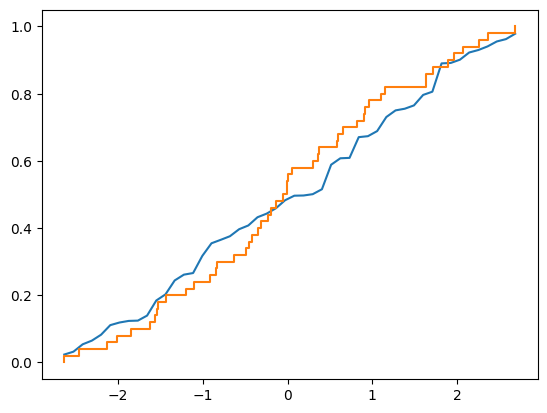

In [87]:
#ЭФР
plt.plot(np.linspace(min(error), max(error), N), Y_error)
plt.plot(X_ecdf, Y_ecdf)
plt.show()

In [88]:
delta_f

0.4958115514170303

### Parametric bootstrap

In [89]:
delta_arr = np.array([])
for i in range(10000):
    error_i = np.random.normal(0, sigma, size = N)
    m_i, sigma_i = error_i.mean(), error_i.var() 
    Y_error_i = norm.cdf(np.sort(error_i), m_i, sigma_i)
    _, Y_ecdf_i = ecdf(error_i)
    delta_i = np.sqrt(N)*(np.max(abs(Y_error_i.repeat(2)-Y_ecdf_i)))
    delta_arr = np.append(delta_arr, delta_i)

In [90]:
delta_arr.sort()

In [91]:
delta_arr

array([0.31533543, 0.32625874, 0.33674557, ..., 1.5023691 , 1.51749204,
       1.61452546])

In [92]:
k_ = sum(delta_arr < delta_f)
k_ += 1

p_value_f = 1 - (k_ - 1)/10000
print(f"p_value by Kolmogorov and parametric_bootstrap = {p_value_f}")

p_value by Kolmogorov and parametric_bootstrap = 0.973


### Нет оснований отвергнуть гипотезу о нормальности распределения ошибки

## g) исследовать регрессию на выбросы 

In [93]:
sigma_g = np.median(abs(error))/0.675
sigma_g

1.3611020074393698

In [94]:
row_del = []
N_g = N
for i,e in enumerate(error):
    if e<=-2*sigma_g or e>=2*sigma_g:
        N_g -=1
        row_del.append(i)
        print(i,e)

In [95]:
data_g = np.delete(data, (row_del), axis=0)
target_g = np.delete(target, row_del)
psi_g = np.ones((N_g,1))
psi_g = np.hstack([psi_g, data_g])

F_g = psi_g.T @ psi_g
F_1_g = np.linalg.inv(F_g)
beta_g = F_1_g@psi_g.T @ target_g
rss_g = (target_g - psi_g @ beta_g).T @ (target_g-psi_g @ beta_g)
tss_g = np.sum((target_g-target_g.mean())**2) 

In [96]:
R_2_g = 1-rss_g/tss_g 
print(f"R2 до удаления выбросов: {R_2}, после: {R_2_g}")

R2 до удаления выбросов: 0.7689599986761178, после: 0.7689599986761178


## h) провести кросс-проверку регрессии

In [97]:
CV_array = np.array([])
for i in range(N):
    data_h = np.delete(data, i, axis=0)
    target_h = np.delete(target, i)
    psi_h = np.ones((N-1, 1))
    psi_h = np.hstack([psi_h, data_h])
    
    F_h = psi_h.T @ psi_h
    F_1_h = np.linalg.inv(F_h)
    beta_h = F_1_h @ psi_h.T @ target_h
    CV_array = np.append(CV_array, (np.insert(data[i], 0, 1)@beta_h - target[i])**2)

In [98]:
R_cv = 1- np.sum(CV_array)/tss

In [99]:
R_cv

0.6911524303614199

### Качество прогноза немного уменьшилось 

## i) Проверить адекватность регрессии, сделав 5 повторных измерений в одной точке

In [100]:
# let's fix ξ = 1
k = 5
teta_arr = np.array([])
for i in range(k):
    teta_arr = np.append(teta_arr, np.random.normal(2+np.sum(coef*1), 1.5))
variance_5 = 1/(k-1)*np.sum((teta_arr - np.mean(teta_arr))**2)
delta_5 = rss/((N-p)*variance_5)

In [101]:
p_value_5 = f.sf(delta_5, N-p, k-1)

In [102]:
print(f"p_value: {p_value_5}")

p_value: 0.458867159487151


### больше 0.05, значит нет оснований отвергнуть гипотезу $H_0$ о равенстве дисперсий

## j) удалить переменную, соответствующую наименеезначимому коэффициенту и повторить пункты b и c

In [103]:
p_value_coef.argmax() # наименее значимый коэффициент

3

In [104]:
data_j = np.delete(data, p_value_coef.argmax(), axis=1)

In [105]:
psi_j = np.ones((N,1))
psi_j = np.hstack([psi_j, data_j])

F_j = psi_j.T @ psi_j
F_1_j = np.linalg.inv(F_j)
beta_j = F_1_j@psi_j.T @ target
rss_j = (target - psi_j @ beta_j).T @ (target - psi_j @ beta_j)
tss_j = np.sum((target - target.mean())**2) 

In [106]:
print(f"{beta_j[0]:.2f} + {beta_j[1]:.2f}ξ1 + {beta_j[2]:.2f}ξ2 + {beta_j[3]:.2f}ξ4 + {beta_j[4]:.2f}ξ5") 

1.83 + 2.83ξ1 + -2.05ξ2 + 1.29ξ4 + -1.18ξ5


### Проверка значимости

In [107]:
p_value_coef_j =  np.array([])
for i in range(len(beta_j)):
    delta_j = beta_j[i]/(np.sqrt(rss_j*F_1_j[i,i]))*np.sqrt(N-p)
    p_value_coef_j = np.append(p_value_coef_j, 2*t.sf(abs(delta_j), N-p))
    print(f"p-value for feach {i}: {2*t.sf(abs(delta_j), N-p)}") #t.sf = 1-t.cdf, t.cdf - функция распределения(даёт значение)

p-value for feach 0: 5.641546604800948e-09
p-value for feach 1: 1.1865705445993821e-07
p-value for feach 2: 1.6921746627227525e-05
p-value for feach 3: 0.0059335627833040205
p-value for feach 4: 0.0041683374283028


In [108]:
print(f"коэффициент детерминации, после удаления наименее значимого коэффициента {(tss_j-rss_j)/tss_j}")

коэффициент детерминации, после удаления наименее значимого коэффициента 0.6609482685076776


## k) Сравнить уравнение регрессии бутстрапом
## $H_0:$ 4 признака и свободный член, $H_1:$ 5 признаков и свободный член

In [113]:
delta_k = (rss_j - rss)/rss*(N - p)/(p - (p-1)) #исходная дельта 

In [156]:
def get_bootstrap_samples(data, target, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices], target[indices]

In [163]:
delta_k_arr = np.array([])

for i in range(1000):
    data_k, target_k = get_bootstrap_samples(data, target, 1)
    data_k, target_k = data_k[0], target_k[0]
    data_k_5 = np.delete(data_k, p_value_coef.argmax(), axis=1)
    
    psi_k = np.ones((N,1))
    psi_k_5 = np.hstack([psi_k, data_k_5]) # Тут 4 признака и свободный член
    psi_k = np.hstack([psi_k, data_k]) # Тут 5 признаков и свободный член
    
    rss_k = (target_k - psi_k @ beta).T @ (target_k - psi_k @ beta)
    rss_k_5 = (target_k - psi_k_5 @ beta_j).T @ (target_k - psi_k_5 @ beta_j)
    
    delta_k_arr = np.append(delta_k_arr, (rss_k_5 - rss_k)/rss_k*(N - p)/(p - (p-1)))

    

In [169]:
delta_k_arr.sort()

In [174]:
k_k = sum(delta_k_arr < delta_k)
k_k += 1

p_value_k = 1 - (k_k - 1)/1000
print(f"p_value bootstrap = {p_value_k}")

p_value bootstrap = 0.477


## значение больше 0.05 Значит нет оснований отвергнуть основную гипотезу, т.е. добавление признака не значимо